In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import random

from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import gym
from gym.spaces import Discrete, Tuple

from env import MetaGames
from rmax_1 import RmaxAgent, Memory

def discretize(number, radius):
     #return (torch.round(torch.div(number, radius))) * radius
     #change not made: originally: [0,3,6,9], now: [0,1,2,3]
     return torch.round(torch.div(number, radius)) * radius

In [3]:
inner_gamma = 0.9         #inner game discount factor
meta_gamma = 0.9          #meta game discount factor
meta_alpha = 0.4          #meta game learning rate
R_max = 0.98
max_meta_epi = 3000
max_meta_steps = 500

epsilon = 0.2
radius = 3                #radius for discretization, assuming radius>1

#reward tensor for plotting purposes [episode, step, agents]
plot_rew = torch.zeros(max_meta_epi, max_meta_steps, 2).to(device)    

# creating environment
env = MetaGames("PD")

memory = Memory()
rmax = RmaxAgent(env, R_max, meta_gamma, inner_gamma, radius, epsilon)

In [ ]:
for episode in tqdm(range(max_meta_epi)): #for each meta-episode
    #initialise meta-state and meta-action randomly
    meta_s = rmax.index_to_table(env, random.randint(0, rmax.meta_size * env.num_agents), env.num_agents)
    memory.states.append(meta_s) 
    
    for step in range(max_meta_steps):    #for each meta time step
        #previous meta-state set as the policy of the next game
        env.innerq = meta_s.detach().clone() #
        #--------------------------------------START OF INNER GAME--------------------------------------
        #reset environment 
        env.reset()   

        #select inner-action with epsilon greedy 
        best_action = env.select_action().detach().clone()      

        #run inner game according to best_action
        reward, info = env.step(best_action)  

        #update inner r matrix [agent, action]
        env.innerr[0, int(best_action[0])] = reward.detach().clone() 
        env.innerr[1, int(best_action[1])] = info.detach().clone()

        #---------------------------------------END OF INNER GAME--------------------------------------
        #save reward, info for plotting              
        plot_rew[episode,step,0] = reward.detach().clone()
        plot_rew[episode,step,1] = info.detach().clone()
        
        #meta-action = inner game Q table of our agent
        meta_a = env.innerq[0, :].detach().clone()
        memory.actions.append(meta_a) 
        
        #Compute new inner Q table, our agent: by Q learning, oppo: max of Q table by putting in previous meta-s
        env.innerq[0, :] = (1-meta_alpha) * env.innerq[0, :] + meta_alpha * torch.Tensor([1-int(best_action[1]), int(best_action[1])]).to(device) * info.detach().clone()
        
        #find index inside dictionary that corresponds to meta_s entry
        #array of indices that corresponds to meta_s
        stateind_arr = np.where(rmax.Q["state"] == rmax.find_meta_index(torch.flatten(meta_s)))[0]
        if len(stateind_arr) == 0:        #if we haven't visited that meta_s before & no record, 
            #we put random meta_action as inner Q
            env.innerq[1, :] = discretize(rmax.index_to_table(env, random.randint(0, rmax.meta_size), 1), radius)
        
        else:                             #else if we visited that meta_s before
            #inner Q is the action that corresponds to max Q(meta_s)
            maxQ_ind = np.argmax([rmax.Q["Qval"][stateind_arr]])
            env.innerq[1, :] = rmax.index_to_table(env, rmax.Q[action][stateind_arr[maxQ_ind]], 1)
            
        #meta-state = discretized inner game Q table of all agents
        next_meta_s = discretize(env.innerq.detach().clone(), radius)
        memory.states.append(next_meta_s)    
        
        #meta-reward = sum of rewards of our agent in inner game of K episodes & T timesteps
        our_REW = reward.detach().clone()                
        memory.rewards.append(reward)
        
        #rmax update step
        rmax.update(env, memory, meta_s, meta_a, next_meta_s)

        #prepare meta_s for next step
        meta_s = next_meta_s.detach().clone()



  6%|███▌                                                        | 175/3000 [54:24<28:39:11, 36.51s/it]

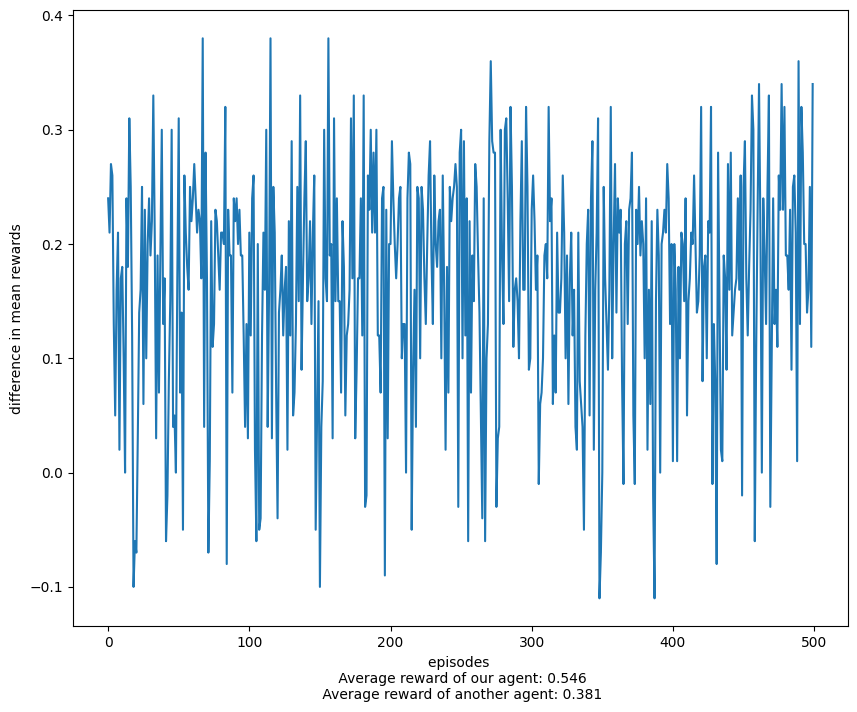

In [11]:
plot_rew_mean_diff = torch.mean(plot_rew[:,:,0],1) - torch.mean(plot_rew[:,:,1],1)
fig_handle = plt.plot(plot_rew_mean_diff.cpu().numpy())

plt.xlabel("episodes \n Average reward of our agent: " + str(round(torch.mean(plot_rew[:,:,0],(0,1)).detach().item(), 3)) + 
          "\n Average reward of another agent: " + str(round(torch.mean(plot_rew[:,:,1],(0,1)).detach().item(), 3)))

plt.ylabel("difference in mean rewards")

figure = plt.gcf() # get current figure
figure.set_size_inches(10, 8)

plt.savefig('inner_gamma' + str(inner_gamma) + '_rad' + str(radius) + '_' + str(max_meta_epi) + '_' + str(max_meta_steps) + '_pd.png' , dpi = 100)